# Dataset

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import re

from textblob import TextBlob
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords

from time import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [2]:
spark = SparkSession.builder.appName('2020ElectionScale').getOrCreate()

In [3]:
all_tweet = spark.read.csv('/Users/mosaic/Desktop/678 Project/all_tweets.csv',
                       inferSchema=True,header=True)

In [4]:
all_tweet.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- tweet: string (nullable = true)



In [5]:
#select all tweet
tweets = all_tweet.select('tweet').collect()

#convert to dataframe
tweet = pd.DataFrame(tweets)

tweet.columns=['tweet']

In [6]:
tweet.head(5)

,tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...
1,None
2,None
3,None
4,None


In [7]:
df = pd.read_csv('/Users/mosaic/Desktop/678 Project/all_tweets.csv', lineterminator='\n')

In [8]:
tweet = df['tweet'].to_frame()

In [10]:
#clean text
def clean(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)
    return text

In [11]:
start = time()
tweet['clear_tweet']=tweet['tweet'].apply(clean)
print(f"run time: {time() - start}")

run time: 100.4984221458435


In [12]:
#check null values
tweet.isnull().sum()

tweet          0
clear_tweet    0
dtype: int64

In [13]:
tweet.head(5)

,tweet,clear_tweet
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,en florida joebiden dice que donaldtrump s...
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,hunterbiden hunterbidenemails joebiden joebide...
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,this is how biden made his trumpisnotamer...
3,@chrislongview Watching and setting dvr. Let’s...,watching and setting dvr let s give him bonu...
4,#censorship #HunterBiden #Biden #BidenEmails #...,censorship hunterbiden biden bidenemails biden...


In [14]:
tweet.shape

(1747805, 2)

# Sentimental Analysis

In [15]:
# create fuction to get the subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'negative'
    elif score==0:
        return 'neutral'
    else:
        return 'positive'

In [16]:
start = time()
tweet['subjectivity']= tweet['clear_tweet'].apply(getSubjectivity)
tweet['polarity']    = tweet['clear_tweet'].apply(getPolarity)
tweet['analysis']    = tweet['polarity'].apply(getAnalysis)
print(f"run time: {time() - start}")

run time: 3380.01486492157


In [17]:
tweet.head(6)

,tweet,clear_tweet,subjectivity,polarity,analysis
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,en florida joebiden dice que donaldtrump s...,0.000000,0.000000,neutral
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,hunterbiden hunterbidenemails joebiden joebide...,0.000000,0.000000,neutral
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,this is how biden made his trumpisnotamer...,0.000000,0.000000,neutral
3,@chrislongview Watching and setting dvr. Let’s...,watching and setting dvr let s give him bonu...,0.000000,0.000000,neutral
4,#censorship #HunterBiden #Biden #BidenEmails #...,censorship hunterbiden biden bidenemails biden...,0.000000,0.000000,neutral
5,"""IS THIS WRONG??!!"" Cory Booker's BRILLIANT Fi...",is this wrong cory booker s brilliant fi...,0.966667,0.133333,positive


# Different Scales

In [18]:
def label_y(target):
    if target=="neutral":
        return 0
    elif target=="positive":
        return 1
    else:
        return -1

In [23]:
X = tweet['clear_tweet'] #clear text as X variable
y = tweet['analysis'].apply(label_y)

## 30% for Test

In [24]:
#split dataset: test size is 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Transform

In [25]:
start_trans = time()
counter = CountVectorizer(stop_words=stopwords.words('english'))
X_train=counter.fit_transform(X_train)
X_test=counter.transform(X_test)

tf = TfidfTransformer()
X_train = tf.fit_transform(X_train)
X_test = tf.transform(X_test)
print(f"run time: {time() - start_trans}")

run time: 196.39591598510742


### MultinomialNB Model

In [26]:
MNB_start = time()
MNB_model = MultinomialNB().fit(X_train, y_train)
MNB_pre = MNB_model.predict(X_test)
MNB_time = time() - MNB_start
print(f"Multinomial NB Model finished, run time: {MNB_time}")
target_names=["neutral","positive","negative"]
print('\n')
print("classification report：", classification_report(y_test, MNB_pre, target_names=target_names))

Multinomial NB Model finished, run time: 0.9273631572723389


classification report：               precision    recall  f1-score   support

     neutral       0.95      0.20      0.33     77861
    positive       0.94      0.77      0.85    290932
    negative       0.54      0.94      0.69    155549

    accuracy                           0.74    524342
   macro avg       0.81      0.64      0.62    524342
weighted avg       0.82      0.74      0.72    524342



In [27]:
MNB_accuracy = MNB_model.score(X_test,y_test)

### Linear SVC Model

In [28]:
LSVC_start = time()
LSVC_model = LinearSVC().fit(X_train,y_train)
LSVC_pre = LSVC_model.predict(X_test)
LSVC_time = time() - LSVC_start
print(f"Linear SVC Model finished, run time: {LSVC_time}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test, LSVC_pre, target_names=target_names))

Linear SVC Model finished, run time: 76.83320808410645
classification report：               precision    recall  f1-score   support

     neutral       0.91      0.87      0.89     77861
    positive       0.96      0.99      0.98    290932
    negative       0.95      0.92      0.94    155549

    accuracy                           0.95    524342
   macro avg       0.94      0.93      0.93    524342
weighted avg       0.95      0.95      0.95    524342



In [29]:
LSVC_accuracy = LSVC_model.score(X_test,y_test)

### SGD Classifier

In [30]:
SGD_start = time()
SGD_model = SGDClassifier().fit(X_train, y_train)
SGD_pre = SGD_model.predict(X_test)
SGD_time = time() - SGD_start
print(f"Linear SVC Model finished, run time: {SGD_time}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test, SGD_pre, target_names=target_names))

Linear SVC Model finished, run time: 14.535693645477295
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.49      0.64     77861
    positive       0.82      0.99      0.90    290932
    negative       0.90      0.75      0.82    155549

    accuracy                           0.85    524342
   macro avg       0.87      0.74      0.78    524342
weighted avg       0.85      0.85      0.83    524342



In [31]:
SGD_accuracy = SGD_model.score(X_test,y_test)

## 20% for Test

In [32]:
#split dataset: test size is 0.2
X = tweet['clear_tweet']
y = tweet['analysis'].apply(label_y)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

start_trans = time()
X_train1=counter.fit_transform(X_train1)
X_test1=counter.transform(X_test1)

X_train1 = tf.fit_transform(X_train1)
X_test1 = tf.transform(X_test1)
print(f"run time: {time() - start_trans}")

run time: 64.02316403388977


### MNB Model

In [33]:
MNB_start1 = time()
MNB_model1 = MultinomialNB().fit(X_train1, y_train1)
MNB_pre1 = MNB_model1.predict(X_test1)
MNB_time1 = time() - MNB_start1
print(f"Multinomial NB Model finished, run time: {MNB_time1}")
target_names=["neutral","positive","negative"]
print('\n')
print("classification report：", classification_report(y_test1, MNB_pre1, target_names=target_names))

Multinomial NB Model finished, run time: 1.0319609642028809


classification report：               precision    recall  f1-score   support

     neutral       0.94      0.21      0.35     51786
    positive       0.94      0.77      0.85    193914
    negative       0.54      0.94      0.69    103861

    accuracy                           0.74    349561
   macro avg       0.81      0.64      0.63    349561
weighted avg       0.82      0.74      0.73    349561



In [34]:
MNB_accuracy1 = MNB_model1.score(X_test1,y_test1)

### LSVC Model

In [35]:
LSVC_start1 = time()
LSVC_model1 = LinearSVC().fit(X_train1,y_train1)
LSVC_pre1 = LSVC_model1.predict(X_test1)
LSVC_time1 = time() - LSVC_start1
print(f"Linear SVC Model finished, run time: {LSVC_time1}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test1, LSVC_pre1, target_names=target_names))

Linear SVC Model finished, run time: 86.1276490688324
classification report：               precision    recall  f1-score   support

     neutral       0.92      0.87      0.89     51786
    positive       0.96      0.99      0.98    193914
    negative       0.95      0.92      0.94    103861

    accuracy                           0.95    349561
   macro avg       0.94      0.93      0.94    349561
weighted avg       0.95      0.95      0.95    349561



In [36]:
LSVC_accuracy1 = LSVC_model1.score(X_test1,y_test1)

### SGD Classifier

In [37]:
SGD_start1 = time()
SGD_model1 = SGDClassifier().fit(X_train1, y_train1)
SGD_pre1 = SGD_model1.predict(X_test1)
SGD_time1 = time() - SGD_start1
print(f"Linear SVC Model finished, run time: {SGD_time1}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test1, SGD_pre1, target_names=target_names))

Linear SVC Model finished, run time: 15.049077987670898
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.49      0.64     51786
    positive       0.82      0.99      0.90    193914
    negative       0.90      0.75      0.82    103861

    accuracy                           0.85    349561
   macro avg       0.87      0.74      0.78    349561
weighted avg       0.85      0.85      0.83    349561



In [38]:
SGD_accuracy1 = SGD_model1.score(X_test1,y_test1)

## 50% for Test

In [39]:
#split dataset: test size is 0.5
X = tweet['clear_tweet']
y = tweet['analysis'].apply(label_y)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.5, random_state=42)

start_trans = time()
X_train2=counter.fit_transform(X_train2)
X_test2=counter.transform(X_test2)

X_train2 = tf.fit_transform(X_train2)
X_test2 = tf.transform(X_test2)
print(f"run time: {time() - start_trans}")

run time: 54.493125915527344


### MNB Model

In [40]:
MNB_start2 = time()
MNB_model2 = MultinomialNB().fit(X_train2, y_train2)
MNB_pre2 = MNB_model2.predict(X_test2)
MNB_time2 = time() - MNB_start2
print(f"Multinomial NB Model finished, run time: {MNB_time2}")
target_names=["neutral","positive","negative"]
print('\n')
print("classification report：", classification_report(y_test2, MNB_pre2, target_names=target_names))

Multinomial NB Model finished, run time: 0.6796929836273193


classification report：               precision    recall  f1-score   support

     neutral       0.95      0.18      0.30    129882
    positive       0.94      0.78      0.85    485449
    negative       0.54      0.94      0.68    258572

    accuracy                           0.73    873903
   macro avg       0.81      0.63      0.61    873903
weighted avg       0.82      0.73      0.72    873903



In [41]:
MNB_accuracy2 = MNB_model2.score(X_test2,y_test2)

### LSVC

In [42]:
LSVC_start2 = time()
LSVC_model2 = LinearSVC().fit(X_train2,y_train2)
LSVC_pre2 = LSVC_model2.predict(X_test2)
LSVC_time2 = time() - LSVC_start2
print(f"Linear SVC Model finished, run time: {LSVC_time2}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test2, LSVC_pre2, target_names=target_names))

Linear SVC Model finished, run time: 53.399697065353394
classification report：               precision    recall  f1-score   support

     neutral       0.91      0.87      0.89    129882
    positive       0.96      0.99      0.97    485449
    negative       0.95      0.92      0.93    258572

    accuracy                           0.95    873903
   macro avg       0.94      0.92      0.93    873903
weighted avg       0.95      0.95      0.95    873903



In [43]:
LSVC_accuracy2 = LSVC_model2.score(X_test2,y_test2)

### SGD classifier

In [44]:
SGD_start2 = time()
SGD_model2 = SGDClassifier().fit(X_train2, y_train2)
SGD_pre2 = SGD_model2.predict(X_test2)
SGD_time2 = time() - SGD_start2
print(f"Linear SVC Model finished, run time: {SGD_time2}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test2, SGD_pre2, target_names=target_names))

Linear SVC Model finished, run time: 11.662014961242676
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.50      0.64    129882
    positive       0.82      0.99      0.90    485449
    negative       0.89      0.75      0.82    258572

    accuracy                           0.85    873903
   macro avg       0.87      0.75      0.79    873903
weighted avg       0.86      0.85      0.84    873903



In [45]:
SGD_accuracy2 = SGD_model2.score(X_test2,y_test2)

## 70% for Test

In [46]:
#split dataset: test size is 0.7
X = tweet['clear_tweet']
y = tweet['analysis'].apply(label_y)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.7, random_state=42)

start_trans = time()
X_train3=counter.fit_transform(X_train3)
X_test3=counter.transform(X_test3)

X_train3 = tf.fit_transform(X_train3)
X_test3 = tf.transform(X_test3)
print(f"run time: {time() - start_trans}")

run time: 56.33349823951721


### MNB Model

In [47]:
MNB_start3 = time()
MNB_model3 = MultinomialNB().fit(X_train3, y_train3)
MNB_pre3 = MNB_model3.predict(X_test3)
MNB_time3 = time() - MNB_start3
print(f"Multinomial NB Model finished, run time: {MNB_time3}")
target_names=["neutral","positive","negative"]
print('\n')
print("classification report：", classification_report(y_test3, MNB_pre3, target_names=target_names))

Multinomial NB Model finished, run time: 0.7848868370056152


classification report：               precision    recall  f1-score   support

     neutral       0.96      0.15      0.26    181761
    positive       0.94      0.78      0.85    679647
    negative       0.54      0.93      0.68    362056

    accuracy                           0.73   1223464
   macro avg       0.81      0.62      0.60   1223464
weighted avg       0.82      0.73      0.71   1223464



In [48]:
MNB_accuracy3 = MNB_model3.score(X_test3,y_test3)

### LSVC

In [49]:
LSVC_start3 = time()
LSVC_model3 = LinearSVC().fit(X_train3,y_train3)
LSVC_pre3 = LSVC_model3.predict(X_test3)
LSVC_time3 = time() - LSVC_start3
print(f"Linear SVC Model finished, run time: {LSVC_time3}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test3, LSVC_pre3, target_names=target_names))

Linear SVC Model finished, run time: 37.14210510253906
classification report：               precision    recall  f1-score   support

     neutral       0.91      0.85      0.88    181761
    positive       0.96      0.99      0.97    679647
    negative       0.95      0.91      0.93    362056

    accuracy                           0.95   1223464
   macro avg       0.94      0.92      0.93   1223464
weighted avg       0.95      0.95      0.95   1223464



In [50]:
LSVC_accuracy3 = LSVC_model3.score(X_test3,y_test3)

### SGD Classifier

In [51]:
SGD_start3 = time()
SGD_model3 = SGDClassifier().fit(X_train3, y_train3)
SGD_pre3 = SGD_model3.predict(X_test3)
SGD_time3 = time() - SGD_start3
print(f"Linear SVC Model finished, run time: {SGD_time3}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test3, SGD_pre3, target_names=target_names))

Linear SVC Model finished, run time: 5.609367847442627
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.50      0.64    181761
    positive       0.82      0.99      0.90    679647
    negative       0.89      0.75      0.82    362056

    accuracy                           0.85   1223464
   macro avg       0.87      0.75      0.79   1223464
weighted avg       0.86      0.85      0.84   1223464



In [52]:
SGD_accuracy3 = SGD_model3.score(X_test3,y_test3)

## 80% for Test

In [53]:
#split dataset: test size is 0.8
X = tweet['clear_tweet']
y = tweet['analysis'].apply(label_y)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.8, random_state=42)

start_trans = time()
X_train4=counter.fit_transform(X_train4)
X_test4=counter.transform(X_test4)

X_train4 = tf.fit_transform(X_train4)
X_test4 = tf.transform(X_test4)
print(f"run time: {time() - start_trans}")

run time: 57.428467988967896


### MNB Model

In [54]:
MNB_start4 = time()
MNB_model4 = MultinomialNB().fit(X_train4, y_train4)
MNB_pre4 = MNB_model4.predict(X_test4)
MNB_time4 = time() - MNB_start4
print(f"Multinomial NB Model finished, run time: {MNB_time4}")
target_names=["neutral","positive","negative"]
print('\n')
print("classification report：", classification_report(y_test4, MNB_pre4, target_names=target_names))

Multinomial NB Model finished, run time: 0.6001579761505127


classification report：               precision    recall  f1-score   support

     neutral       0.97      0.13      0.23    207637
    positive       0.93      0.79      0.86    776868
    negative       0.54      0.93      0.69    413739

    accuracy                           0.73   1398244
   macro avg       0.81      0.62      0.59   1398244
weighted avg       0.82      0.73      0.71   1398244



In [55]:
MNB_accuracy4 = MNB_model4.score(X_test4,y_test4)

### LSVC

In [56]:
LSVC_start4 = time()
LSVC_model4 = LinearSVC().fit(X_train4,y_train4)
LSVC_pre4 = LSVC_model4.predict(X_test4)
LSVC_time4 = time() - LSVC_start4
print(f"Linear SVC Model finished, run time: {LSVC_time4}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test4, LSVC_pre4, target_names=target_names))

Linear SVC Model finished, run time: 20.867680072784424
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.84      0.87    207637
    positive       0.95      0.99      0.97    776868
    negative       0.94      0.91      0.92    413739

    accuracy                           0.94   1398244
   macro avg       0.93      0.91      0.92   1398244
weighted avg       0.94      0.94      0.94   1398244



In [57]:
LSVC_accuracy4 = LSVC_model4.score(X_test4,y_test4)

### SGD Classifier

In [58]:
SGD_start4 = time()
SGD_model4 = SGDClassifier().fit(X_train4, y_train4)
SGD_pre4 = SGD_model4.predict(X_test4)
SGD_time4 = time() - SGD_start4
print(f"Linear SVC Model finished, run time: {SGD_time4}")
target_names=["neutral","positive","negative"]
print("classification report：", classification_report(y_test4, SGD_pre4, target_names=target_names))

Linear SVC Model finished, run time: 4.566961765289307
classification report：               precision    recall  f1-score   support

     neutral       0.90      0.51      0.65    207637
    positive       0.83      0.99      0.90    776868
    negative       0.89      0.76      0.82    413739

    accuracy                           0.85   1398244
   macro avg       0.87      0.75      0.79   1398244
weighted avg       0.86      0.85      0.84   1398244



In [59]:
SGD_accuracy4 = SGD_model4.score(X_test4,y_test4)

# Scale vs. Time

In [60]:
scale = [20, 30, 50, 70, 80] #training sample scale

In [61]:
creat_time = {'MNB': [MNB_time4, MNB_time3, MNB_time2, MNB_time, MNB_time1],
              'LSVC': [LSVC_time4, LSVC_time3, LSVC_time2, LSVC_time, LSVC_time1],
              'SGD': [SGD_time4, SGD_time3, SGD_time2, SGD_time, SGD_time1]}
time = pd.DataFrame(data=creat_time)

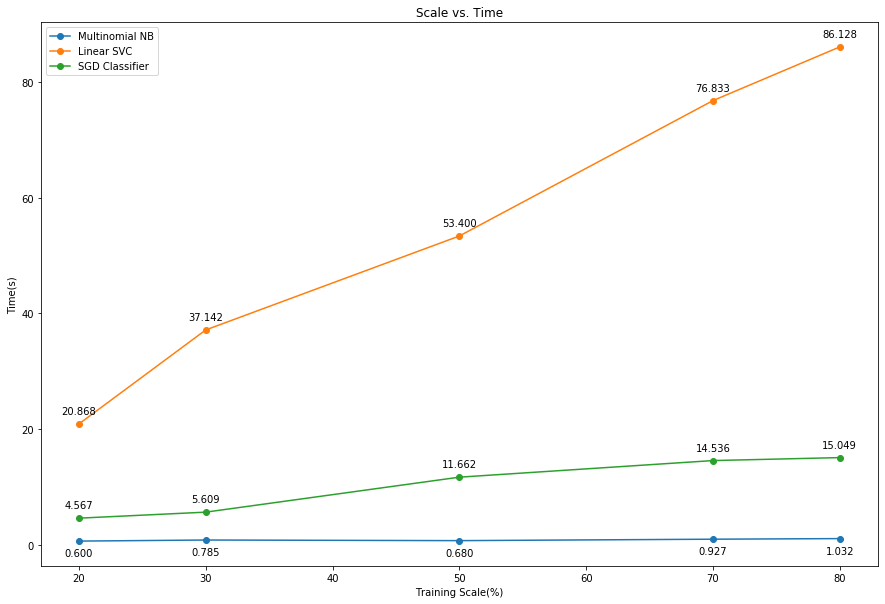

In [103]:
plt.figure(figsize=(15,10))
plt.plot(scale, time['MNB'], label='Multinomial NB', marker='o')
plt.plot(scale, time['LSVC'], label='Linear SVC', marker='o')
plt.plot(scale, time['SGD'], label='SGD Classifier', marker='o')

plt.xlabel('Training Scale(%)')
plt.ylabel('Time(s)')
plt.title('Scale vs. Time')
plt.legend()

# zip joins x and y coordinates in pairs
for x,y in zip(scale,time['MNB']):

    label = "{:.3f}".format(y)
    
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y in zip(scale,time['LSVC']):
    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
    
for x,y in zip(scale,time['SGD']):
    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Scale vs. Accuracy

In [63]:
creat_accuracy = {'MNB': [MNB_accuracy4, MNB_accuracy3, MNB_accuracy2, MNB_accuracy, MNB_accuracy1],
              'LSVC': [LSVC_accuracy4, LSVC_accuracy3, LSVC_accuracy2, LSVC_accuracy, LSVC_accuracy1],
              'SGD': [SGD_accuracy4, SGD_accuracy3, SGD_accuracy2, SGD_accuracy, SGD_accuracy1]}
accuracy = pd.DataFrame(data=creat_accuracy)

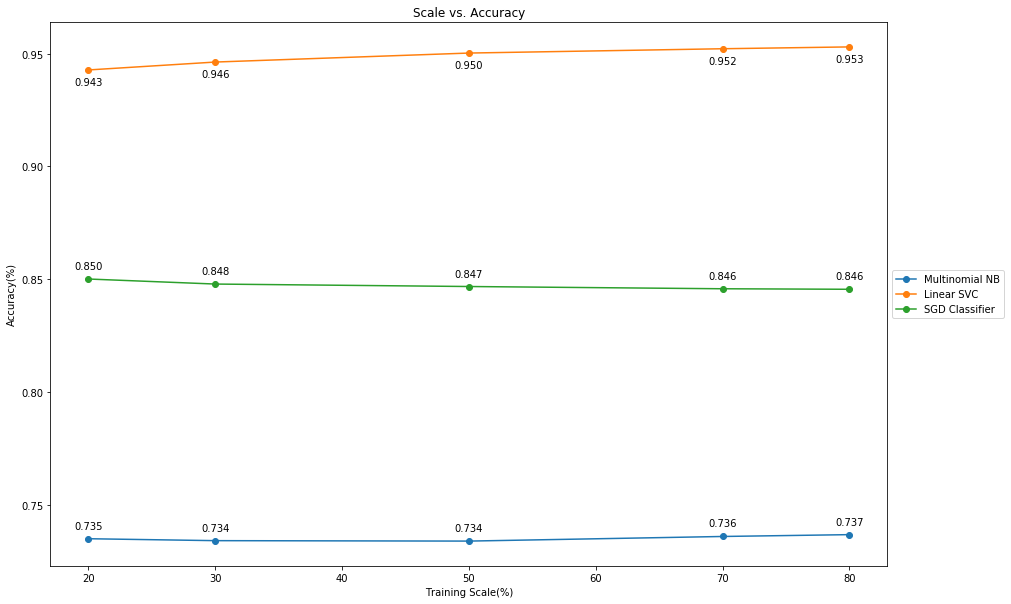

In [104]:
plt.figure(figsize=(15,10))
plt.plot(scale, accuracy['MNB'], label='Multinomial NB', marker='o')
plt.plot(scale, accuracy['LSVC'], label='Linear SVC', marker='o')
plt.plot(scale, accuracy['SGD'], label='SGD Classifier', marker='o')

plt.xlabel('Training Scale(%)')
plt.ylabel('Accuracy(%)')
plt.title('Scale vs. Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# zip joins x and y coordinates in pairs
for x,y in zip(scale,accuracy['MNB']):

    label = "{:.3f}".format(y)
    
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y in zip(scale,accuracy['LSVC']):
    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,-15), 
                 ha='center')
    
for x,y in zip(scale,accuracy['SGD']):
    label = "{:.3f}".format(y)
    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

# Time vs. Accuracy

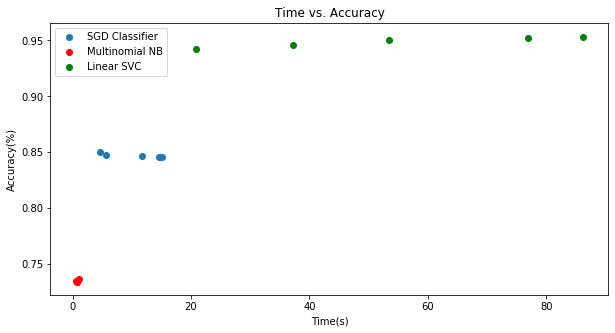

In [147]:
plt.figure(figsize=(10,5))

plt.scatter(time['SGD'], accuracy['SGD'], label='SGD Classifier' )
plt.scatter(time['MNB'], accuracy['MNB'], label='Multinomial NB', color='red')
plt.scatter(time['LSVC'], accuracy['LSVC'], label='Linear SVC', color='green')

plt.xlabel('Time(s)')
plt.ylabel('Accuracy(%)')
plt.title('Time vs. Accuracy')
plt.legend()